In [2]:
import astropy as ap
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as filt
from scipy.ndimage import shift
from scipy.optimize import minimize

In [3]:
def mpc_reader(filename):

    """
    Read in a file with observations in MPC format and return the coordinates.

    Inputs
    ------
    filename: str
        The name of the file with the MPC-formatted observations.

    Returns
    -------
    c: astropy SkyCoord object
        A SkyCoord object with the ra, dec of the observations.
    """
    iso_times = []
    time_frac = []
    ra = []
    dec = []

    with open(filename, 'r') as f:
        for line in f:
            year = str(line[15:19])
            month = str(line[20:22])
            day = str(line[23:25])
            iso_times.append(str('%s-%s-%s' % (year,month,day)))
            time_frac.append(str(line[25:31]))
            ra.append(str(line[32:44]))
            dec.append(str(line[44:56]))

    c = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

    return c

In [137]:
def load_pg_nums(file_path):
    found_object_filenames = os.listdir(file_path)
    pg_nums = []
    ccd_nums = []
    indexes = []
    for file in found_object_filenames:
        if file[-4:] == '.png':
            pg_nums.append(int(file[0:3]))
            ccd_nums.append(int(file[4:6]))
            indexes.append(int(file[-8:-4]))
    return(pg_nums, ccd_nums, indexes)

def load_visits(file_path):
    fits_filenames = os.listdir(file_path)
    visits = []
    for file in fits_filenames:
        if file[-5:] == '.fits':
            visits.append(int(file[0:-5]))
    return(visits)

class fitMag:
    def __init():
        return()
    
    def get_stamps(self, traj_radec, traj_visits, stamp_size=21):
        calexp_path_format = ('/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'+
        'Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/'+
        'calexp-{visit:07d}_{ccd:02d}.fits')

        traj_stamps = []
        traj_seeing = []
        traj_weights = []
        traj_magzero = []
        for ii in range(len(traj_radec)):
            image_path = calexp_path_format.format(pg=pg_nums[i],ccd=ccd_nums[i],visit=traj_visits[ii])
            #print(image_path)
            traj_hdul = fits.open(image_path)
            fitsHeader0 = fits.getheader(image_path,0)
            fitsHeader1 = fits.getheader(image_path,1)
            traj_seeing.append(fitsHeader0['DIMMSEE'])
            traj_magzero.append(fitsHeader0['MAGZERO'])
            #print(fitsHeader0['MAGZERO']-2.5*np.log10(fitsHeader0['FLUXMAG0']))
            # Load the world coordinate system and find the pixel values
            traj_wcs = WCS(fitsHeader1)

            x, y = traj_radec[ii].to_pixel(traj_wcs)

            xmin = int(x-(stamp_size-1)/2+0.5)-1
            xmax = int(x+(stamp_size-1)/2+0.5)
            ymin = int(y-(stamp_size-1)/2+0.5)-1
            ymax = int(y+(stamp_size-1)/2+0.5)

            traj_stamps.append(traj_hdul[1].data[ymin:ymax,xmin:xmax])
            traj_weights.append(1/traj_hdul[3].data[ymin:ymax,xmin:xmax])
        return(traj_stamps, traj_weights, traj_magzero, traj_seeing)
    
    def model_images(self, x):
        mdl = shift(self.psf, x)
        return mdl

    def bestfluxes(self, x):
        freg = 250000 # width of flux prior

        mdl = self.model_images(x)
        a = np.sum(mdl*mdl*self.weights) + freg**-2
        c = np.sum(mdl*self.stamps*self.weights)
        return c / a

    def negloglike(self, x):

        mdl = self.model_images(x)
        f = self.bestfluxes(x)
        if f<0:
            f=0

        bestmdl = f*mdl
        logL = 0.5 * np.sum(self.weights*(bestmdl-self.stamps)**2)
        return logL
    
    def maximize_counts(self, x):
        mdl = self.model_images(x)
        flux = np.sum(mdl*self.stamps)
        background = np.sum((1-mdl)/np.sum(1-mdl)*self.stamps)
        return(-flux+background*np.sum(mdl))

    def get_mag(self, traj_stamps, traj_weights, traj_magzero, traj_seeing, stamp_size=21, psf_type='gaussian'):
        traj_flux = []
        best_fit_result = []
        for ii in range(len(traj_stamps)):
            self.stamps = traj_stamps[ii]
            self.weights = traj_weights[ii]
            #self.weights = np.ones(np.shape(traj_stamps[ii]))
            window = (stamp_size-1)/2
            arcsec_per_pixel = 0.26
            y, x = np.mgrid[-window:window+1,-window:window+1]
            psf_fwhm = traj_seeing[ii]/arcsec_per_pixel
            
            if psf_type=='gaussian':
                
                s = psf_fwhm / 2.355
                self.psf = np.exp(-(x*x+y*y)/(2*s*s))/(2*np.pi*s*s)
                
                result = minimize(self.negloglike,[0,0])
                best_fit_result.append(result)
                best_flux = self.bestfluxes(result['x'])
                
            elif psf_type=='circle':
                # Create a circular aperture
                self.psf = np.ones(np.shape(self.stamps)) 
                self.psf[np.sqrt(x*x+y*y)>psf_fwhm*2] = 0
                result = minimize(self.maximize_counts,[0,0])
                best_fit_result.append(result)
                best_flux = -self.maximize_counts(result['x'])

            if best_flux<0:
                best_flux=0
            traj_flux.append(best_flux)

        traj_mag = -2.5*(np.log10(traj_flux)) + traj_magzero
        return(traj_mag, traj_flux, best_fit_result)

def plot_stamps(traj_stamps, result, stamp_size=21):
    window = (stamp_size-1)/2
    fig, ax = plt.subplots(ncols=5, nrows=4, figsize=[8,6])
    ax = ax.reshape(-1)
    for ii, ax0 in enumerate(ax):
        ax0.imshow(traj_stamps[ii])
        ax0.scatter(result[ii]['x'][1]+window,result[ii]['x'][0]+window, marker='x',s=500,c='k')
            

In [145]:
stamp_size = 21

pg_nums, ccd_nums, indexes = load_pg_nums('./saved_trajectory_images/known_objects/kbmod_stamps/')
#print(pg_nums)
i=5
print(pg_nums[i], ccd_nums[i])
traj_radec = mpc_reader('{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_nums[i], ccd_nums[i], indexes[i]))
traj_visits = load_visits('/epyc/users/smotherh/good_warps_good_seeing/{:03d}/{:02d}/'.format(pg_nums[i],ccd_nums[i]))
fit_mag = fitMag()

traj_stamps, traj_weights, traj_magzero, traj_seeing = fit_mag.get_stamps(traj_radec, traj_visits, stamp_size=stamp_size)
traj_mag, traj_flux, results = fit_mag.get_mag(traj_stamps, traj_weights, traj_magzero, traj_seeing, stamp_size=stamp_size, psf_type='circle')

192 36


In [149]:
for j in range(len(results)):
    res = results[j]
    ftol = 2.220446049250313e-09
    for i in range(len(res.x)):
        hess_inv_i = np.diag(res.hess_inv)[i]
        uncertainty_i = np.sqrt(max(1, abs(res.fun)) * ftol * hess_inv_i)
        print('x^{0} = {1:12.4e} ± {2:.1e}'.format(i, res.x[i], uncertainty_i))

x^0 =   2.2091e+00 ± 5.5e-05
x^1 =   3.5452e+00 ± 9.0e-05
x^0 =   3.1857e+00 ± 1.3e-04
x^1 =   2.7075e+00 ± 1.1e-04
x^0 =   2.2048e+00 ± 6.7e-05
x^1 =   2.0679e+00 ± 6.7e-05
x^0 =   2.9130e+00 ± 6.0e-05
x^1 =   2.9347e+00 ± 9.1e-05
x^0 =   3.2011e+00 ± 6.4e-05
x^1 =   1.1600e+00 ± 5.3e-05
x^0 =   1.6761e+00 ± 9.3e-05
x^1 =   4.4681e-02 ± 9.9e-05
x^0 =   1.0233e+00 ± 6.1e-05
x^1 =   3.6560e+00 ± 7.8e-05
x^0 =   3.1058e+00 ± 5.5e-05
x^1 =   2.1531e-01 ± 5.2e-05
x^0 =   3.8467e+00 ± 7.0e-05
x^1 =   2.2850e+00 ± 7.7e-05
x^0 =   3.7293e+00 ± 7.7e-05
x^1 =   4.3616e+00 ± 9.2e-05
x^0 =   1.0988e+00 ± 5.3e-05
x^1 =   1.1010e-01 ± 4.1e-05
x^0 =   1.8949e+00 ± 5.3e-05
x^1 =   1.5870e+00 ± 9.4e-05
x^0 =   4.0020e+00 ± 5.0e-05
x^1 =   3.0164e+00 ± 8.3e-05
x^0 =   4.7379e+00 ± 6.2e-05
x^1 =   1.9163e+00 ± 4.7e-05
x^0 =   1.4275e-01 ± 4.7e-05
x^1 =   1.8270e+00 ± 7.7e-05
x^0 =   3.2774e+00 ± 4.3e-05
x^1 =  -3.0723e+00 ± 4.7e-05
x^0 =   1.0561e+00 ± 5.0e-05
x^1 =  -5.0690e-02 ± 4.5e-05
x^0 =  -1.8614

In [146]:
print(traj_mag)
print(np.var(traj_mag))
print(np.median(traj_mag))

[24.22834779 24.453998   24.59489949 24.51818048 24.18477668 25.41836082
 24.50683921 24.27502742 25.01756518 24.3510618  25.46978977 24.76357996
 24.95972364 24.72293599 24.75772661 24.08086786 24.22425948 24.19464384
 24.19810654 24.08816022]
0.16304805694776506
24.48041860772519


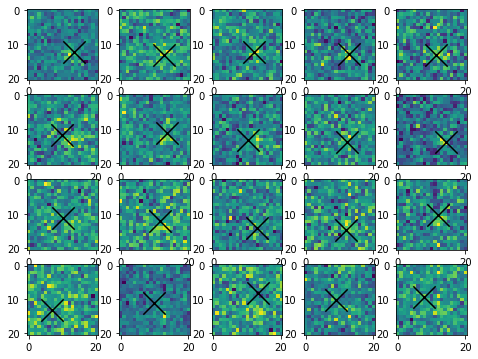

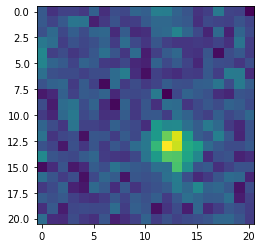

In [148]:
plot_stamps(traj_stamps, results)
plt.figure()
plt.imshow(np.sum(traj_stamps,axis=0))

In [96]:
stamp_size = 21

pg_nums, ccd_nums, indexes = load_pg_nums('./saved_trajectory_images/known_objects/kbmod_stamps/')
median_mag = []
all_mags = []
for i in range(len(pg_nums)):
    traj_radec = mpc_reader('{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_nums[i], ccd_nums[i], indexes[i]))
    traj_visits = load_visits('/epyc/users/smotherh/good_warps_good_seeing/{:03d}/{:02d}/'.format(pg_nums[i],ccd_nums[i]))
    fit_mag = fitMag()
    traj_stamps, traj_weights, traj_magzero, traj_seeing = fit_mag.get_stamps(traj_radec, traj_visits, stamp_size=stamp_size)
    traj_mag, traj_flux, results = fit_mag.get_mag(traj_stamps, traj_weights, traj_magzero, traj_seeing, stamp_size=stamp_size, psf_type='circle')
    median_mag.append(np.median(traj_mag))
    all_mags.append(traj_mag)
    print(np.median(traj_mag))

23.985465293295352


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.928129424075856


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.777049008537976


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.989137181655234
24.139438368657473
24.408693765204234
24.201436465732286
24.741024143479187
22.23971206392531
24.416612139810965
24.647556268215826
23.964733572153214


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


25.019246975665574
23.966823477015684
24.475763032658975
24.624192813293483
22.653036395773356


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.68836528987564
23.26745372926746


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.39770036076261
23.234522443223597
23.424047579101334
22.90145587449012
22.92856003691097
23.362044607832914


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


22.94821882379253
23.011117874108454


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.930379631237145
22.38397055923474
22.85117411271801
23.20807878900831
23.168690899478555
23.064692104614934
24.606688006164113
24.422038025147923


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.5177237365409
24.143765911836276
24.84045792425411


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.60897796209971
24.462722578238356
22.84197759574587


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.75326601446229
24.128434613082955
23.87884155655253
23.596698401612052
23.444718097712048


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.708726534350546
23.43221053825917
24.271728270179366
24.18254890435961


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


24.57146125827373
23.950314639074186
24.04049198131088
24.004775619620812
24.07075520279052
24.37108096864675
24.135846450575876


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


24.261188967989412
23.44615686112698
23.590680647575468
22.595520576030296


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.678718607715176
23.24774501124724
23.89350497951396
23.407207218785096


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.53872608904416
23.507523320482647
23.82075960241518
23.83519102660721
23.248985327741917


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.845759496030112
23.60024617151287
23.329820150517612


/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: divide by zero encountered in log10


23.947917065045022
22.37734842932594


<ErrorbarContainer object of 3 artists>

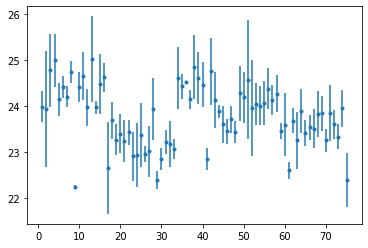

In [97]:
sigmaG_coeff =  0.7413
variance = []
sigmaG_list = []
for i in range(len(all_mags)):
    mags = all_mags[i]
    per25,per50,per75 = np.percentile(mags,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    mags_mask = np.logical_and(mags>(per50-2*sigmaG),mags<(per50+2*sigmaG))
    variance.append(np.var(mags[mags_mask]))
    sigmaG_list.append(sigmaG)

x = np.linspace(1,len(median_mag),len(median_mag))

plt.errorbar(x,median_mag, sigmaG_list,ls='',marker='.')


In [98]:
#np.savetxt('unidentified_objects_median_mag_circle_magzero.txt',[median_mag, sigmaG_list])

In [21]:
unidentified_median_mags, unidentified_sigmaG_list = np.loadtxt('unidentified_objects_median_mag_circle_magzero.txt')
known_median_mags, sigmaG_list = np.loadtxt('known_objects_median_mag_circle_magzero.txt')

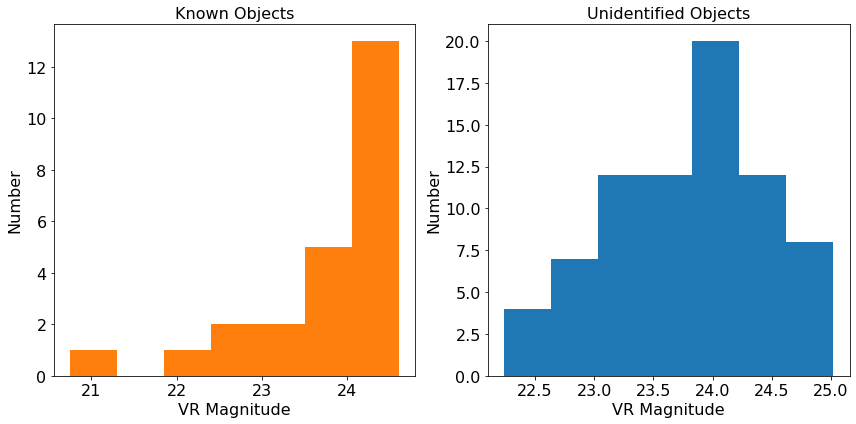

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,6])
ax[1].hist(unidentified_median_mags,bins='fd', color='tab:blue')
ax[1].set_xlabel('VR Magnitude',fontsize=16)
ax[1].set_ylabel('Number',fontsize=16)
#ax[1].set_xlim([20.5,25.5])
ax[1].set_title('Unidentified Objects', fontsize=16)

ax[0].hist(known_median_mags,bins='fd', color='tab:orange')
ax[0].set_xlabel('VR Magnitude',fontsize=16)
ax[0].set_ylabel('Number',fontsize=16)
#ax[0].set_xlim([20.5,25.5])
ax[0].set_title('Known Objects', fontsize=16)
ax[0].tick_params(labelsize=16)
ax[1].tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('VR_Mag.pdf')

# Compare to Fraser 2008

In [15]:
from scipy import interpolate
from astropy import coordinates
from astropy import units as u
import ephem
import pandas as pd
from scipy.integrate import quad

## Using inclination distribution of Brown (2001) and his conversion to a latitudinal distribution
def lat_dist(x, b):
    a = 0.83
    sig_1 = 2.6
    sig_2 = 15.0
    return (np.sin(x)*(a*np.exp((-(np.degrees(x)/sig_1)**2.)/2.) + (1.-a)*np.exp((-(np.degrees(x)/sig_2)**2.)/2.))*
            (np.cos(b)/np.sqrt(np.sin(x)**2. - np.sin(b)**2.)))

def load_pg_nums(file_path):
    found_object_filenames = os.listdir(file_path)
    pg_nums = []
    ccd_nums = []
    indexes = []
    for file in found_object_filenames:
        if file[-4:] == '.png':
            pg_nums.append(int(file[0:3]))
            ccd_nums.append(int(file[4:6]))
            indexes.append(int(file[-8:-4]))
    return(pg_nums, ccd_nums, indexes)

def fraser_err(m, alpha, m_0, gmr_color):
    
    dalpha = ((m-(m_0+gmr_color))**2.)*(0.05**2.)
    dm0 = (alpha**2.)*(0.13**2.)
    
    return np.sqrt(dalpha + dm0)*scaled_area*10**(alpha*(bin_midpoints-(m_0+gmr_color)))

def get_discovery_ecliptic(dir_path, filenames):

    disc_vals = []
    
    for filename in filenames:
        with open(os.path.join(dir_path, filename)) as f:
            for line in f:
                ra_hour = line[32:34]
                ra_min = line[35:37]
                ra_sec = line[38:44]
                dec_deg = line[44:47]
                dec_min = line[48:50]
                dec_sec = line[51:56]
                break

        coords = ["%s %s %s %s %s %s" % (ra_hour, ra_min, ra_sec, dec_deg, dec_min, dec_sec)]
        c = coordinates.SkyCoord(coords, frame="icrs", unit=(u.hourangle, u.deg))
        eq = ephem.Equatorial(ephem.hours(c.ra.rad), ephem.degrees(c.dec.rad))
        ec = ephem.Ecliptic(eq)
        disc_vals.append([np.degrees(ec.lon), np.degrees(ec.lat)])

    disc_props = np.array(disc_vals)
    disc_props = pd.DataFrame(disc_props, columns=['lon', 'lat'])
    
    return disc_props

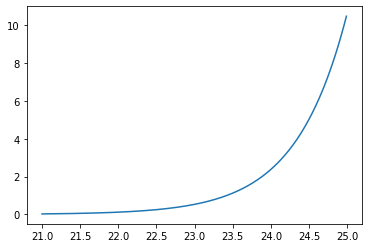

In [16]:
## Using parameters from Fraser et al. (2008) "The Kuiper Belt Luminosity Function from mR = 21 to 26."
m_0 = 23.42
alpha = 0.65
m_range = np.arange(21., 25, 0.01)
plt.plot(m_range, 10**(alpha*(m_range-m_0)))

In [150]:
# Load the ecliptic lat and lon for the searched pointing groups
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointingswSeeing.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
search_pg_nums = np.loadtxt('/epyc/users/smotherh/xsede_results/search_pg_list.txt',dtype=int)
pointing_lat = []
pointing_lon = []
for i in search_pg_nums:
    ra = Pointing_Groups[i]['ra'][0]
    dec = Pointing_Groups[i]['dec'][0]

    c = coordinates.SkyCoord(ra, dec, frame="icrs", unit=(u.deg, u.deg))
    eq = ephem.Equatorial(ephem.hours(c.ra.rad), ephem.degrees(c.dec.rad))
    ec = ephem.Ecliptic(eq)
    
    pointing_lat.append(np.degrees(ec.lat))
    pointing_lon.append(np.degrees(ec.lon))
pointing_lat = np.array(pointing_lat)

In [4]:
# Estimate fill factor
average_kbo_vel = 275 #pixel per day
average_kbo_ang = 4.4 #radians
min_time_baseline = 3 #days
y_fill_factor = np.abs(np.sin(average_kbo_ang)*average_kbo_vel*min_time_baseline)/(4096)
x_fill_factor = np.abs(np.cos(average_kbo_ang)*average_kbo_vel)*min_time_baseline/(2048)
net_fill_factor = x_fill_factor + y_fill_factor*(1-x_fill_factor)
print('====================================================================================')
print('Fill Factor Estimation:')
print('====================================================================================')
print('The typical net fill factor due to trajectories hitting chip edges is: {:.3f}'.format(1-net_fill_factor))

Fill Factor Estimation:
The typical net fill factor due to trajectories hitting chip edges is: 0.708


In [223]:
lat_vals = [quad(lat_dist, lat_val, np.pi/2., args=(lat_val,))[0] for lat_val in np.arange(0, np.pi/2., .01)]
field_radians = np.radians(np.abs(pointing_lat))
field_scaling = [quad(lat_dist, lat_val, np.pi/2., args=(lat_val,))[0] for lat_val in field_radians]
field_scaling /= np.max(lat_vals)
scaled_area = np.sum(field_scaling*3.)
scaled_area_fill_factor = np.sum(field_scaling*3.*(0.55)) # Assume 50% fill factor

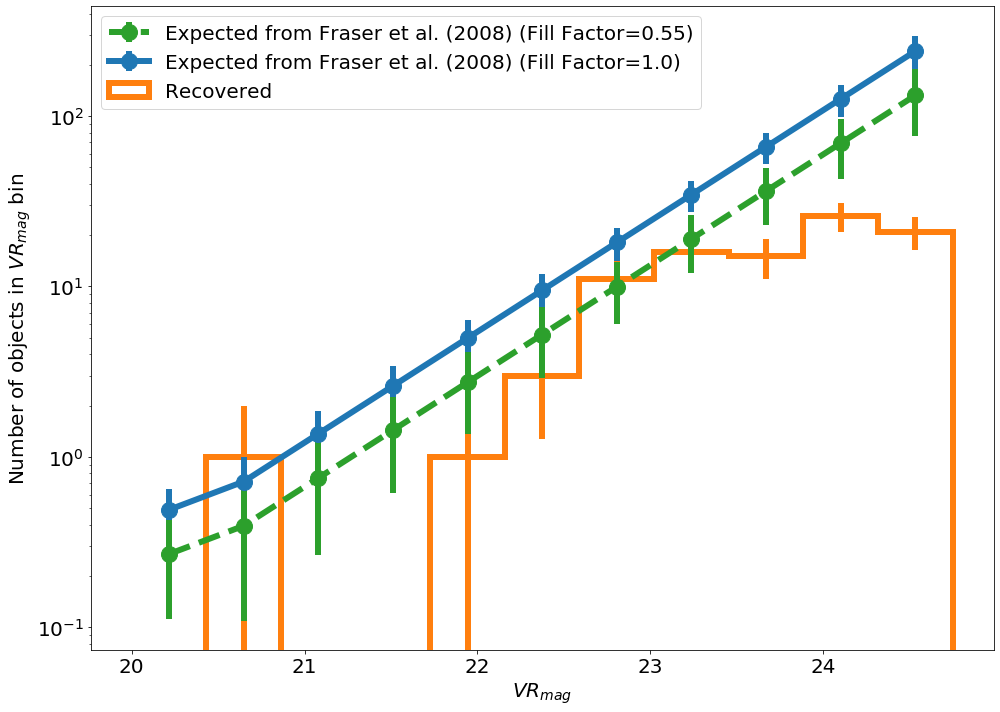

In [225]:
#n_mag, bins_mag, _ = plt.hist(l7_hits['H'])
#gmr_color = 0.95
VRmr_color=0.03
fig = plt.figure(figsize=(14,10))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
# Histogram of all VR mags recovered with KBMOD
n_magf, bins, _ = plt.hist(np.concatenate([unidentified_median_mags,known_median_mags]), histtype='step', lw=6, label='Recovered', color='tab:orange', bins='fd', range=(20., 24.75))

# Use bin midpoints as inputs for estimating expected number of objects
bin_midpoints = (bins[:-1] + bins[1:]) / 2.
bin_spacing = bins[1] - bins[0]
bin_midpoints = np.insert(bin_midpoints, 0, bins[0] - bin_spacing)
plt.errorbar(bin_midpoints[1:], n_magf, yerr=np.sqrt(n_magf), marker='', ms=16, lw=6, ls='', color='tab:orange')

bin_cum = scaled_area*10**(alpha*(bin_midpoints-(m_0+VRmr_color)))
cum_err = fraser_err(bin_midpoints, alpha, m_0, VRmr_color)
bin_diff = bin_cum[1:] - bin_cum[:-1]
diff_err = np.sqrt(cum_err[1:]**2. + cum_err[:-1]**2.)
plt.errorbar(bin_midpoints[1:], bin_diff, yerr=diff_err, marker='o', ms=16, lw=6, label='Expected from Fraser et al. (2008) (Fill Factor=1.0)', c='tab:blue')

bin_cum = scaled_area_fill_factor*10**(alpha*(bin_midpoints-(m_0+VRmr_color)))
cum_err = fraser_err(bin_midpoints, alpha, m_0, VRmr_color)
bin_diff = bin_cum[1:] - bin_cum[:-1]
diff_err = np.sqrt(cum_err[1:]**2. + cum_err[:-1]**2.)
plt.errorbar(bin_midpoints[1:], bin_diff, yerr=diff_err, marker='o',ls='--', ms=16, lw=6, label='Expected from Fraser et al. (2008) (Fill Factor=0.55)', c='tab:green')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],fontsize=20, loc=2)
plt.xlabel(r'$VR_{mag}$', size=20)
plt.ylabel(r'Number of objects in $VR_{mag}$ bin', size=20)
plt.yscale('log')
#plt.title('Magnitude Distribution Comparison', size=24)
plt.tight_layout()
#plt.savefig('Mag_Comparison.pdf')



301 46
203 9
203 43
 
1.151 x - 3.001


Text(0, 0.5, 'VR')

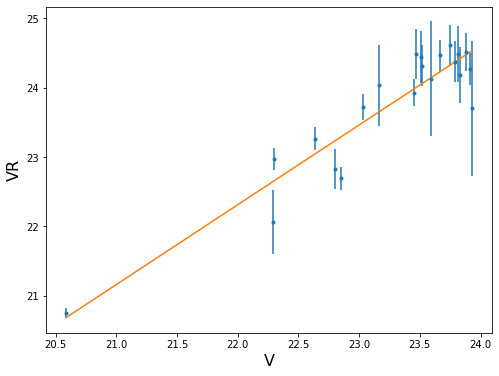

In [73]:
known_object_data_path = '/epyc/users/smotherh/LoriAllen/pointing_metadata/known_objects/known_KBO_data_lh15.pkl'
with open(known_object_data_path, 'rb') as f:
    allObjectData = pickle.load(f)
known_format = "pg{:03d}_ccd{:02d}"
Horizon_Vmag = []
for i in range(len(pg_nums)):
    try:
        Horizon_Vmag.append(allObjectData[known_format.format(pg_nums[i],ccd_nums[i])][1])
    except:
        Horizon_Vmag.append(0)
        print(pg_nums[i], ccd_nums[i])
Horizon_Vmag = np.array(Horizon_Vmag)

plt.figure(figsize=[8,6])
plt.errorbar(Horizon_Vmag[Horizon_Vmag!=0],known_median_mags[Horizon_Vmag!=0],sigmaG_list[Horizon_Vmag!=0],ls='',marker='.')
x = Horizon_Vmag[Horizon_Vmag!=0]
y = known_median_mags[Horizon_Vmag!=0]
print(np.poly1d(np.polyfit(x, y, 1)))
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('V', fontsize=16)
plt.ylabel('VR', fontsize=16)